In [1]:
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
from pylab import rcParams

In [9]:
rcParams['figure.figsize'] = 12, 24

In [3]:
from ImageHandler import *
from ImageProcessing import *

Found 1569 components with height 21.18992989165073 in image


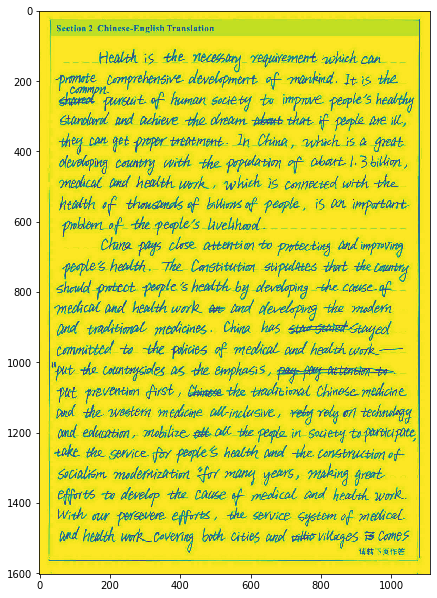

In [4]:
image = cv.imread(cv.samples.findFile("Test-data/050200074.jpg"), 0);
(h, w) = np.shape(image);
plt.imshow(image)
width = int (findComponents(image));

In [15]:
# replace pixel with avg gray value 
def PPA(image, width):
    stripped_image, strips = putGLM(np.copy(image), width);
    plt.imshow(stripped_image);
    plt.show();
    
    # apply otsu's algo
    th = np.copy(stripped_image);
    for i in range(strips):
        l = i * width;
        r = (i+1) * width if (((i+1) * width) < w) else w
        _,th[:,l:r] = cv.threshold(stripped_image[:,l:r],0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    plt.imshow(th);
    plt.show();
    
    filteredWImage = filterWhite(np.copy(th), strips, width)
    plt.imshow(filteredWImage);
    plt.show();
    
    filteredBImage = filterBlackH(np.copy(filteredWImage), strips, width)
    plt.imshow(filteredBImage);
    plt.show();
    
    mode = modeWhite(np.copy(filteredBImage), strips, width);
    return mode, filteredBImage;

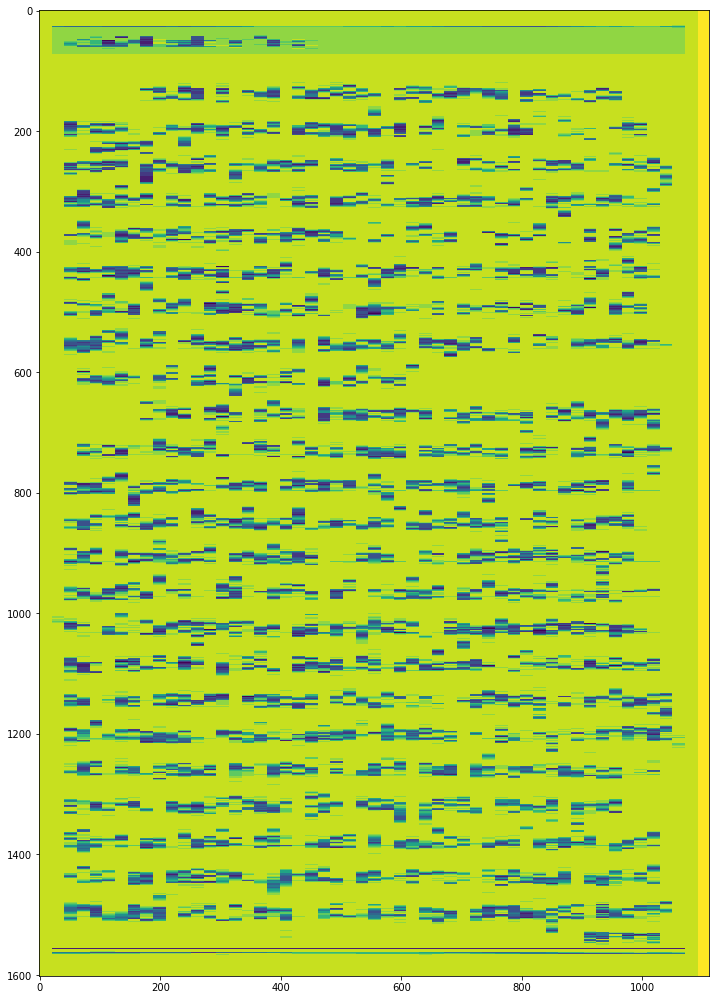

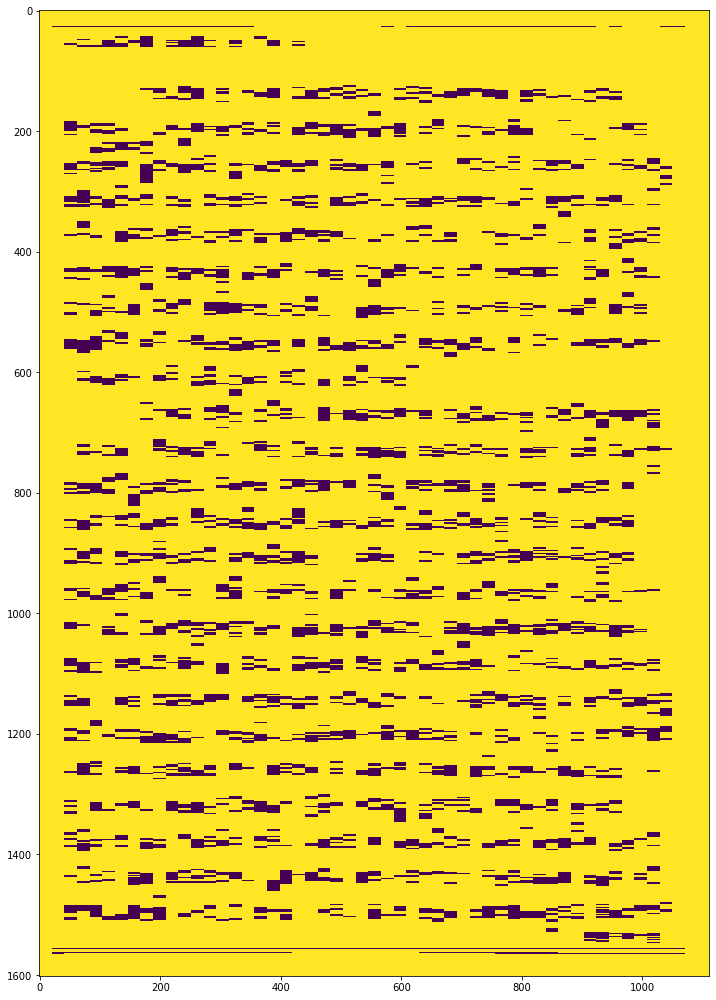

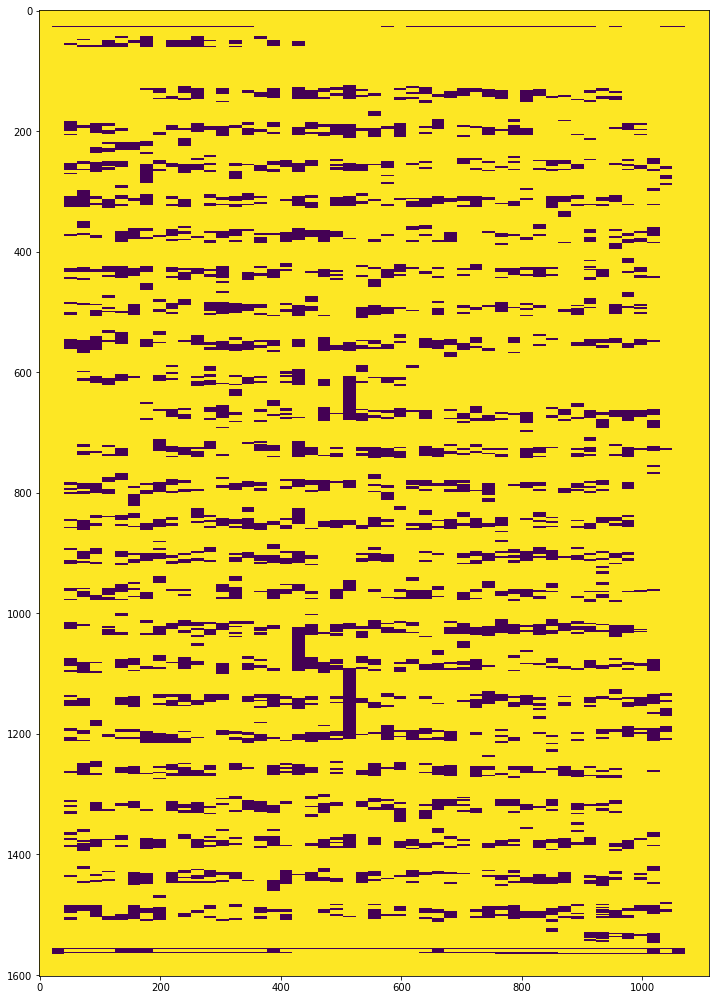

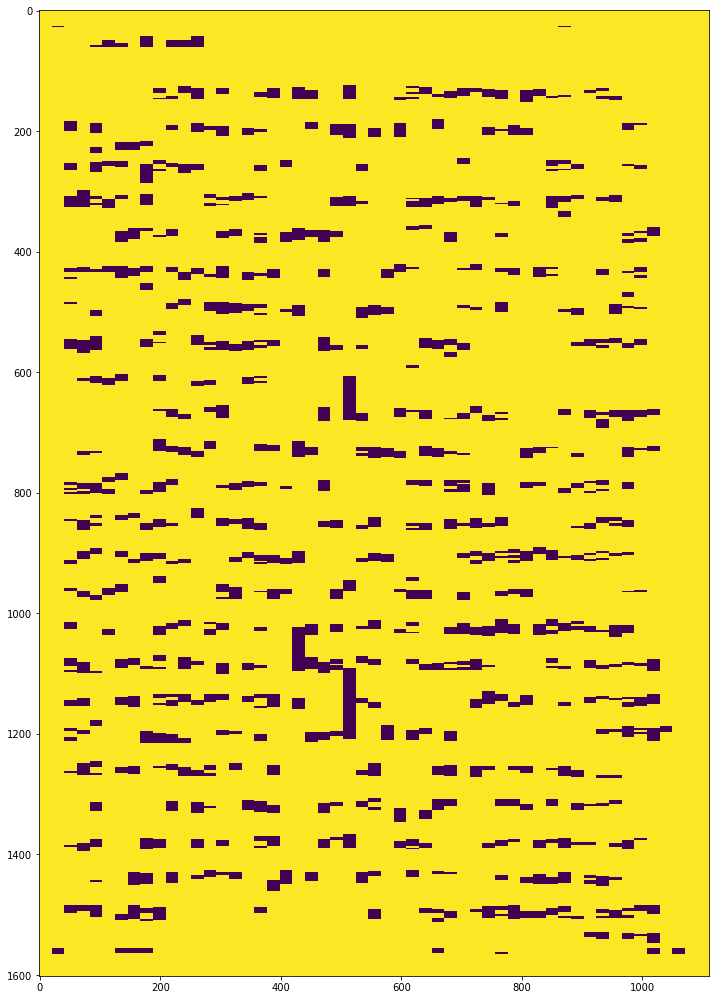

In [13]:
mode, filteredBImage = PPA(image, width)

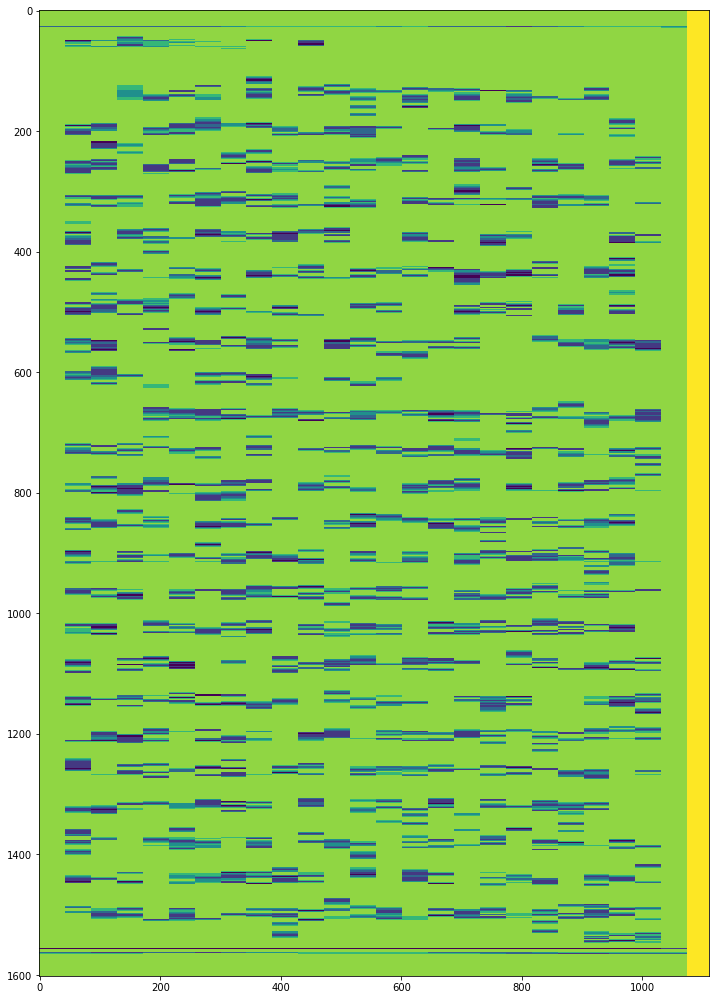

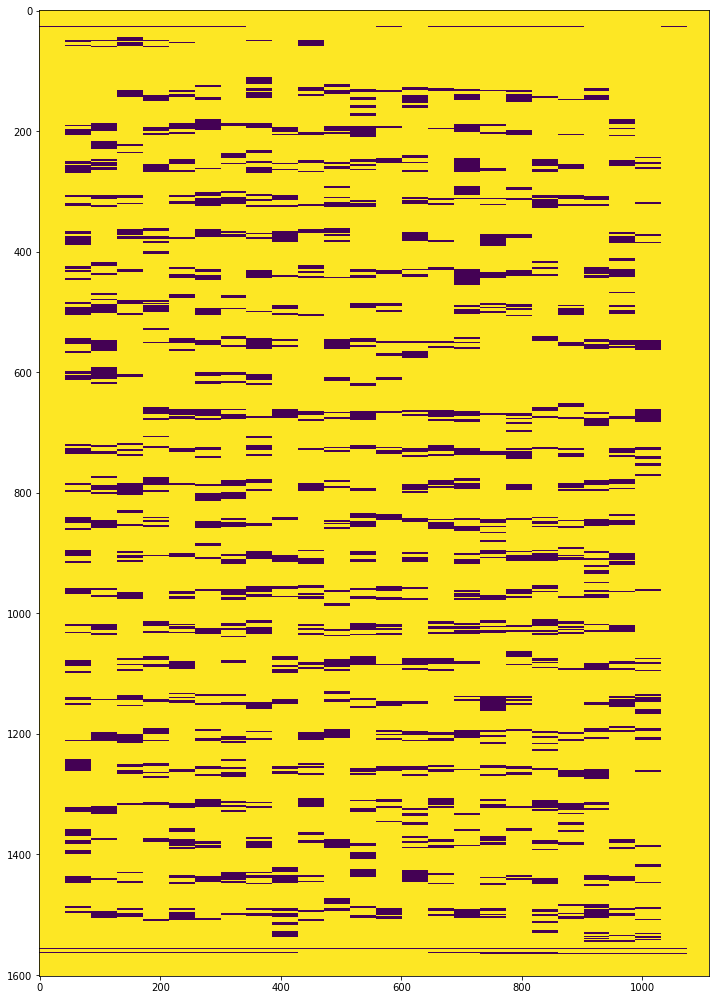

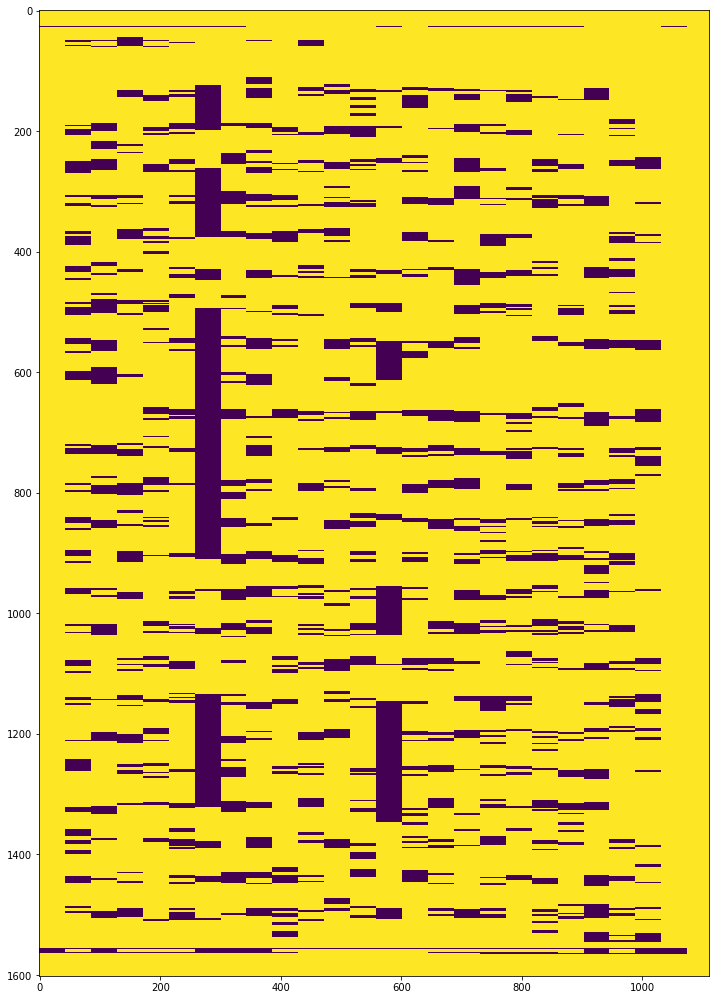

27
29
[]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
mode, filteredBImage = PPA(image, mode)

In [18]:
def filterBlackH(image, strips, width):
    (h, w) = np.shape(image);
    value = 0;

    for i in range(strips):
        l = i * width;
        r = (i+1) * width if (((i+1) * width) < w) else w;
        heights = [];
        tempH = 0;
        for j in range(h):
            if (image[j,l] == value):
                tempH += 1;
            elif (tempH != 0):
                heights.append(tempH);
                tempH = 0;

        if (heights != []):
            m = int (mean([heights[i] for i in range(len(heights)) if i%8 ==0]))
        else:
            continue;

        start = -1;
        for j in range(h):
            if (image[j,l] == value):
                if (start == -1):
                    start = j;
                tempH += 1;
            elif (tempH != 0):
                print (start)
                print (j)
                if ((tempH < m) or (tempH < 3*m and checkDangleH(image[start:j,l-1 if l!= 0 else 0:r+1 if r]))):
                    image[start:j,l:r] = np.ones((j-start, r-l)) * 255;
                tempH = 0;
                start = -1;
    return image;

def checkDangleH(image):
    print (image)
    for row in image:
        if (row[0] == 0 or row[-1] == 0):
            return False;
    return True;